# Making a lookup table of the u-i vs. g-z colours


In [1]:
# Need to switch directories if using VS Code + sshfs
GALAXY = "NGC4380"
GALPATH = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{GALAXY}/"
%cd "$GALPATH"
# 
import astropy.coordinates as coord
import astropy.units as u
import dill
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.io import fits
from astropy.wcs import WCS
from scipy.stats import gaussian_kde
# 
# Load my own packages
# 
import sys
sys.path.append("/arc/home/IsaacCheng/coop_f2021/packages")
import fits_utils as fu
import plot_utils as pu
import radial_profile_utils as rpu
from radial_profile import RadialProfile
# Reload my packages
import importlib
importlib.reload(fu)
importlib.reload(pu)
importlib.reload(rpu)
# 
GALDIST = 16.5 * u.Mpc  # distance to centre of Virgo cluster. Assume 10% uncertainty

/arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380


## Step 0 (already ran. do not run again. only have to run this once)

Ensure each bin is only represented once


In [ ]:
from numba import njit, prange
from itertools import repeat
from multiprocessing import Pool


@njit(parallel=False)  # will clash with multiprocessing if parallel=True
def select_one_from_each_bin(arr, bin_nums):
    arr = arr.flatten()
    bin_nums = bin_nums.flatten()
    num_bins = int(np.nanmax(bin_nums) + 1)
    tmp_arr = np.full(num_bins, np.nan)
    for i in prange(num_bins):
        tmp_arr[i] = arr[bin_nums == i][0]
    return tmp_arr


def select_one_from_each_bin_multi(arr_of_arrs, bin_nums):
    """
    arrs should be 1d array of arrays
    """
    with Pool(processes=None) as p:
        results = p.starmap(select_one_from_each_bin, zip(arr_of_arrs, repeat(bin_nums)))
    return results


tmp_arr = np.arange(11)
tmp_arr = select_one_from_each_bin(tmp_arr, tmp_arr)


In [ ]:
SNR_TARGET = 50  # specifies which Voronoi-binning file to use
#
# Load Voronoi-binned data
#
vorbin_results = GALPATH + f"{GALAXY}_vorbin_SNR{SNR_TARGET}_ugizBinned.pkl"
with open(vorbin_results, "rb") as f:
    file = dill.load(f)
    uband_signal_vorbin = file["uband_signal"]
    uband_noise_vorbin = file["uband_noise"]
    gband_signal_vorbin = file["gband_signal"]
    gband_noise_vorbin = file["gband_noise"]
    iband_signal_vorbin = file["iband_signal"]
    iband_noise_vorbin = file["iband_noise"]
    zband_signal_vorbin = file["zband_signal"]
    zband_noise_vorbin = file["zband_noise"]
    binNum_vorbin = file["binNum"]
    binNum_arr_vorbin = file["binNum_arr"]
#
# Select only 1 point from each bin (since bins have different sizes and are thus weighted
# differently)
#
arr_of_bands = [
    uband_signal_vorbin,
    uband_noise_vorbin,
    gband_signal_vorbin,
    gband_noise_vorbin,
    iband_signal_vorbin,
    iband_noise_vorbin,
    zband_signal_vorbin,
    zband_noise_vorbin,
]
arr_of_results = select_one_from_each_bin_multi(arr_of_bands, binNum_arr_vorbin)
# Save results
lookup_inputs_outfile = GALPATH + f"{GALAXY}_lookupInputs.pkl"
with open(lookup_inputs_outfile, "wb") as f:
    dill.dump(
        {
            "uband_signal": arr_of_results[0],
            "uband_noise": arr_of_results[1],
            "gband_signal": arr_of_results[2],
            "gband_noise": arr_of_results[3],
            "iband_signal": arr_of_results[4],
            "iband_noise": arr_of_results[5],
            "zband_signal": arr_of_results[6],
            "zband_noise": arr_of_results[7],
            "binNum": binNum_vorbin,
        },
        f,
    )
print("Pickled", lookup_inputs_outfile)


## Step 1

Load data


In [2]:
#
# Load lookup table inputs. These arrays contain 1 data point for each Voronoi-binned bin
#
lookup_inputs_outfile = GALPATH + f"{GALAXY}_lookupInputs.pkl"
with open(lookup_inputs_outfile, "rb") as f:
    file = dill.load(f)
    uband_signal_vorbin = file["uband_signal"]
    uband_noise_vorbin = file["uband_noise"]
    gband_signal_vorbin = file["gband_signal"]
    gband_noise_vorbin = file["gband_noise"]
    iband_signal_vorbin = file["iband_signal"]
    iband_noise_vorbin = file["iband_noise"]
    zband_signal_vorbin = file["zband_signal"]
    zband_noise_vorbin = file["zband_noise"]
    binNum_vorbin = file["binNum"]
#
# Mask for removing bad data
#
# isgood_vorbin = (
#     np.isfinite(uband_signal_vorbin)
#     & np.isfinite(gband_signal_vorbin)
#     & np.isfinite(iband_signal_vorbin)
#     & np.isfinite(zband_signal_vorbin)
#     & np.isfinite(binNum_arr_vorbin)  # not really necessary, but whatever
# )
#
# Calculate colours
#
gz_colour_vorbin = fu.calc_colour(gband_signal_vorbin, zband_signal_vorbin)
ui_colour_vorbin = fu.calc_colour(uband_signal_vorbin, iband_signal_vorbin)
#
# Remove infs and NaNs
#
# gz_colour_vorbin = gz_colour_vorbin[isgood_vorbin]
# ui_colour_vorbin = ui_colour_vorbin[isgood_vorbin]
# 
# Calculate absolute magniutudes
# 
uband_mag, uband_mag_err = fu.calc_mag(uband_signal_vorbin, uband_noise_vorbin, calc_abs=True, dist=GALDIST.to(u.pc).value)
gband_mag, gband_mag_err = fu.calc_mag(gband_signal_vorbin, gband_noise_vorbin, calc_abs=True, dist=GALDIST.to(u.pc).value)
iband_mag, iband_mag_err = fu.calc_mag(iband_signal_vorbin, iband_noise_vorbin, calc_abs=True, dist=GALDIST.to(u.pc).value)
zband_mag, zband_mag_err = fu.calc_mag(zband_signal_vorbin, zband_noise_vorbin, calc_abs=True, dist=GALDIST.to(u.pc).value)


## (Ingore this section)


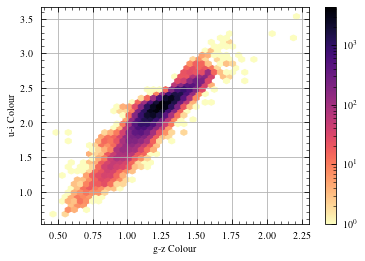

In [6]:
fig, ax = plt.subplots()
hb = ax.hexbin(
    gz_colour_vorbin.flatten(),
    ui_colour_vorbin.flatten(),
    gridsize=40,
    bins="log",  # will change the get_array() values
    mincnt=1,
    cmap="magma_r",
    # extent=[
    #     np.nanmin(gz_colour_vorbin),
    #     np.nanmax(gz_colour_vorbin),
    #     np.nanmin(ui_colour_vorbin),
    #     np.nanmax(ui_colour_vorbin),
    # ],
)
fig.colorbar(hb)
# ax.scatter(
#     gz_colour_vorbin.flatten(),
#     ui_colour_vorbin.flatten(),
#     s=4
# )
ax.set_xlabel("g-z Colour")
ax.set_ylabel("u-i Colour")
plt.show()


In [ ]:
print(hb.get_offsets().shape)
print(hb.get_array().shape)
print(np.sum(~np.isfinite(hb.get_array())))
print(np.sum(hb.get_array() == 0))
print(np.sum(hb.get_array() == 1))

print()
gzvals, uivals = hb.get_offsets()[:, 0], hb.get_offsets()[:, 1]
print(np.min(gzvals), np.max(gzvals))
print(np.min(uivals), np.max(uivals))
print(gzvals.shape)
print(gzvals)
print(uivals)


## Step 2

Make lookup table values and determine the lookup bin of each pixel


In [3]:
# 
# Make 50 x 50 grid for lookup table
# 
LOOKUP_LEN = 50
gz_vals = np.linspace(
    np.nanmin(gz_colour_vorbin), np.nanmax(gz_colour_vorbin), LOOKUP_LEN + 1
)
ui_vals = np.linspace(
    np.nanmin(ui_colour_vorbin), np.nanmax(ui_colour_vorbin), LOOKUP_LEN + 1
)
# gz_mesh, ui_mesh = np.meshgrid(gz_vals, ui_vals)
gz_spacing = np.diff(gz_vals)[0]
ui_spacing = np.diff(ui_vals)[0]
print("gz_spacing:", gz_spacing)
print("ui_spacing:", ui_spacing)
print()
#
# Assign each pixel to its bin. If values beyond the edges of the lookup table, assign to
# bin -1
#
# Since the *_vals arrays are increasing & right=False, the returned index satisfies:
# bins[i] <= x < bins[i+1] (since I subtracted 1 from the bin number)
gz_idx = np.digitize(gz_colour_vorbin, gz_vals, right=False) - 1
ui_idx = np.digitize(ui_colour_vorbin, ui_vals, right=False) - 1
# Use small epsilon (1e-12) to avoid floating point comparison errors
gz_idx_mask = (
    ((np.min(gz_vals) - gz_colour_vorbin) > 1e-12)
    | ((gz_colour_vorbin - np.max(gz_vals)) > 1e-12)
    | np.isnan(gz_colour_vorbin)
)
ui_idx_mask = (
    ((np.min(ui_vals) - ui_colour_vorbin) > 1e-12)
    | ((ui_colour_vorbin - np.max(ui_vals)) > 1e-12)
    | np.isnan(ui_colour_vorbin)
)
# Negative index indicates bad value
gz_idx[gz_idx_mask] = -1
ui_idx[ui_idx_mask] = -1
# Fix right edge condition (e.g., map bin 50 to bin 49)
gz_idx[gz_idx == LOOKUP_LEN] = LOOKUP_LEN - 1
ui_idx[ui_idx == LOOKUP_LEN] = LOOKUP_LEN - 1
# Print some values for sanity check
# print(gz_idx.shape)
# print(gz_idx[0])
# print(gz_colour_vorbin[0])
# print(gz_vals[36])
# print(np.min(gz_idx))
# print(np.min(gz_idx[gz_idx > -1]))
# print(np.max(gz_idx))
# print(np.max(gz_idx[gz_idx < np.max(gz_idx)]))
# print()
# print(ui_idx.shape)
# print(ui_idx[0])
# print(ui_colour_vorbin[0])
# print(ui_vals[45])
# print(np.min(ui_idx))
# print(np.min(ui_idx[ui_idx > -1]))
# print(np.max(ui_idx))
# print(np.max(ui_idx[ui_idx < np.max(ui_idx)]))


gz_spacing: 0.034900468624855074
ui_spacing: 0.05720250290556317



## Step 3

Assign each pixel to its lookup bin


In [4]:
#
# Make pandas dataframe containing the bins in the rows and band fluxes in the columns.
# The row headers will have a format <g-z bin>_<u-i bin>
#
rows = []
for gz_bin in range(LOOKUP_LEN):
    for ui_bin in range(LOOKUP_LEN):
        rows.append(f"{gz_bin}_{ui_bin}")
lookup_df = pd.DataFrame(
    columns=["u", "u_err", "g", "g_err", "i", "i_err", "z", "z_err"], index=rows
).astype("object")
print(lookup_df)
# print(lookup_df.dtypes)


         u u_err    g g_err    i i_err    z z_err
0_0    NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
0_1    NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
0_2    NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
0_3    NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
0_4    NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
...    ...   ...  ...   ...  ...   ...  ...   ...
49_45  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
49_46  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
49_47  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
49_48  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
49_49  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN

[2500 rows x 8 columns]


In [5]:
#
# Populate pandas dataframe
#
nan_arr = np.array([np.nan])


def _assign_to_df(_band, _mask):
    _tmp_arr = _band[_mask]
    if _tmp_arr.size == 0:
        _tmp_arr = nan_arr
    return _tmp_arr


for gz_bin in range(LOOKUP_LEN):
    for ui_bin in range(LOOKUP_LEN):
        tmp_row = f"{gz_bin}_{ui_bin}"
        tmp_mask = (gz_idx == gz_bin) & (ui_idx == ui_bin)
        # lookup_df.at[tmp_row, "u"] = _assign_to_df(uband_signal_vorbin, tmp_mask)
        # lookup_df.at[tmp_row, "u_err"] = _assign_to_df(uband_noise_vorbin, tmp_mask)
        # lookup_df.at[tmp_row, "g"] = _assign_to_df(gband_signal_vorbin, tmp_mask)
        # lookup_df.at[tmp_row, "g_err"] = _assign_to_df(gband_noise_vorbin, tmp_mask)
        # lookup_df.at[tmp_row, "i"] = _assign_to_df(iband_signal_vorbin, tmp_mask)
        # lookup_df.at[tmp_row, "i_err"] = _assign_to_df(iband_noise_vorbin, tmp_mask)
        # lookup_df.at[tmp_row, "z"] = _assign_to_df(zband_signal_vorbin, tmp_mask)
        # lookup_df.at[tmp_row, "z_err"] = _assign_to_df(zband_noise_vorbin, tmp_mask)
        lookup_df.at[tmp_row, "u"] = _assign_to_df(uband_mag, tmp_mask)
        lookup_df.at[tmp_row, "u_err"] = _assign_to_df(uband_mag_err, tmp_mask)
        lookup_df.at[tmp_row, "g"] = _assign_to_df(gband_mag, tmp_mask)
        lookup_df.at[tmp_row, "g_err"] = _assign_to_df(gband_mag_err, tmp_mask)
        lookup_df.at[tmp_row, "i"] = _assign_to_df(iband_mag, tmp_mask)
        lookup_df.at[tmp_row, "i_err"] = _assign_to_df(iband_mag_err, tmp_mask)
        lookup_df.at[tmp_row, "z"] = _assign_to_df(zband_mag, tmp_mask)
        lookup_df.at[tmp_row, "z_err"] = _assign_to_df(zband_mag_err, tmp_mask)


In [6]:
lookup_df


,u,u_err,g,g_err,i,i_err,z,z_err
0_0,[-5.33507010282073],[0.020267060783800323],[-5.522363940562766],[0.015551286338740556],[-6.008304254787468],[0.030827696317815078],[-5.988863138027785],[0.04912624588971917]
0_1,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
0_2,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
0_3,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
0_4,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
...,...,...,...,...,...,...,...,...
49_45,[-5.371202571833244],[0.022098912959298344],[-6.79060077519966],[0.007087528172855396],[-8.61870104936034],[0.004935569760263981],[-8.972229732616984],[0.00530866078038192]
49_46,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
49_47,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
49_48,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]


In [7]:
def get_longest_row(df, col):
    return max(df[col], key=len)


print(len(get_longest_row(lookup_df, "u")))
print(len(get_longest_row(lookup_df, "u_err")))
print(len(get_longest_row(lookup_df, "g")))
print(len(get_longest_row(lookup_df, "g_err")))
print(len(get_longest_row(lookup_df, "i")))
print(len(get_longest_row(lookup_df, "i_err")))
print(len(get_longest_row(lookup_df, "z")))
print(len(get_longest_row(lookup_df, "z_err")))
print(get_longest_row(lookup_df, "u"))
print(get_longest_row(lookup_df, "u_err"))
print(get_longest_row(lookup_df, "g"))
print(get_longest_row(lookup_df, "g_err"))
print(get_longest_row(lookup_df, "i"))
print(get_longest_row(lookup_df, "i_err"))
print(get_longest_row(lookup_df, "z"))
print(get_longest_row(lookup_df, "z_err"))


3250
3250
3250
3250
3250
3250
3250
3250
[-6.11057437 -6.11048096 -6.11904382 ... -6.95868561 -7.31542136
 -6.92029694]
[0.011131   0.01113158 0.01107897 ... 0.02094392 0.01806131 0.0205929 ]
[-7.3375564  -7.32401874 -7.31061961 ... -8.23328175 -8.57281895
 -8.11538303]
[0.00445194 0.00448355 0.00451509 ... 0.00676679 0.00591475 0.0071318 ]
[-8.36027456 -8.36105612 -8.34316885 ... -9.22601751 -9.56659194
 -9.1399694 ]
[0.00488366 0.00488152 0.00493075 ... 0.00933414 0.00816547 0.00956565]
[-8.58504778 -8.59249748 -8.564838   ... -9.49542573 -9.81607523
 -9.3683451 ]
[0.0054952  0.0054707  0.00556233 ... 0.01171784 0.01044246 0.01244874]


## Step 4

Save results for SED fitting


In [8]:
# 
# Check that the number of pixels in each column in the same row are all the same. Passed
# 
# for gz_bin in range(LOOKUP_LEN):
#     for ui_bin in range(LOOKUP_LEN):
#         tmp_row = f"{gz_bin}_{ui_bin}"
#         tmp_series = lookup_df.loc[tmp_row].values
#         tmp_mysize = tmp_series[0].size
#         for i in range(tmp_series.size):
#             if tmp_series[i].size != tmp_mysize:
#                 print("Failed on", tmp_row)
# 
# Select max of 10 random pixels per 2D bin
# 
MAX_PX_PER_BIN = 10
selected_pixels = []
# 
# First row of the text file
# 
# selected_pixels.append(["id", "z", "counts_u", "err_u", "counts_g", "err_g", "counts_i", "err_i", "counts_z", "err_z"])
selected_pixels.append(["id", "z", "u_mag", "u_mag_err", "g_mag", "g_mag_err", "i_mag", "i_mag_err", "z_mag", "z_mag_err"])
# 
rng = np.random.default_rng(761)
len_digits = len(str(LOOKUP_LEN))
for gz_bin in range(LOOKUP_LEN):
    for ui_bin in range(LOOKUP_LEN):
        tmp_row = f"{gz_bin}_{ui_bin}"
        tmp_series = lookup_df.loc[tmp_row]
        tmp_num_px = tmp_series.values[0].size  # number of pixels in the bin
        if tmp_num_px > MAX_PX_PER_BIN:
            tmp_row_idx = rng.integers(0, tmp_num_px, size=MAX_PX_PER_BIN)
        else:
            tmp_row_idx = range(tmp_num_px)
        # 
        tmp_id = str(gz_bin).zfill(len_digits) + str(ui_bin).zfill(len_digits)
        if tmp_num_px == 1:
            if np.isnan(float(tmp_series["u"])):  # don't bother adding NaNs
                continue
            selected_pixels.append(
                [
                    tmp_id,
                    0.0,
                    float(tmp_series["u"]),
                    float(tmp_series["u_err"]),
                    float(tmp_series["g"]),
                    float(tmp_series["g_err"]),
                    float(tmp_series["i"]),
                    float(tmp_series["i_err"]),
                    float(tmp_series["z"]),
                    float(tmp_series["z_err"]),
                ]
            )
        else:
            for i in tmp_row_idx:
                selected_pixels.append(
                    [
                        tmp_id,
                        0.0,
                        float(tmp_series["u"][i]),
                        float(tmp_series["u_err"][i]),
                        float(tmp_series["g"][i]),
                        float(tmp_series["g_err"][i]),
                        float(tmp_series["i"][i]),
                        float(tmp_series["i_err"][i]),
                        float(tmp_series["z"][i]),
                        float(tmp_series["z_err"][i]),
                    ]
                )


In [ ]:
for selected_pixels_row in selected_pixels:
    print(selected_pixels_row)
# print(selected_pixels)


In [9]:
# 
# Save the selected pixels to text file for SED fitting
# 
import csv

# selected_pixels_filename = GALPATH + f"{GALAXY}_lookupFluxes.txt"
selected_pixels_filename = GALPATH + f"{GALAXY}_lookupMagnitudes.txt"
with open(selected_pixels_filename, "w") as f:
    wr = csv.writer(f, delimiter=" ")
    wr.writerows(selected_pixels)
print("Saved", selected_pixels_filename)

Saved /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380/NGC4380_lookupMagnitudes.txt
